# Classifying Attributes that Best Predict Heart Disease

#### Introduction

According to Statistics Canada, heart disease is the second leading cause of death in 2019, accounting for 18.5% of all deaths. So by using the Heart Disease data set, we will determine the three attributes (i.e. characteristics or factors) that can best predict the presence of heart disease in a person. 
The data set contains four datasets concerning heart-disease related characteristics, and each data set contains 14 attributes organized into 14 variables and 302 observations. All the data is of type double, and they were collected from the following institutes:
1. Cleveland Clinic Foundation (cleveland.data)
2. Hungarian Institute of Cardiology, Budapest (hungarian.data)
3. V.A. Medical Center, Long Beach, CA (long-beach-va.data)
4. University Hospital, Zurich, Switzerland (switzerland.data)


#### Preliminary Exploratory Data Analysis

In [ ]:
library(tidyverse)
library(repr)
library(broom)
library(GGally)
library(tidymodels)
library(data.table)
options(repr.matrix.max.rows = 6)

In [ ]:
set.seed(2000)

heart_disease_data <- read_csv(url('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'))

We set the seed so our code is reproduceable and loaded in our heart disease data.

In [4]:
names(heart_disease_data) <- c("age", "sex", "chest_pain_type", "resting_bp", "chol", "fasting_blood_sugar", "resting_electrocardiographic_results", "maximum_heart_rate_achieved", "exercise_induced_angina", "oldpeak", "slope", "ca", "thal", "presence_of_h_d")

# male <- heart_disease_data  %>%
# filter(sex == 1) %>%
# mutate(sex = "Male")

# female <- heart_disease_data %>%
# filter(sex == 0) %>%
# mutate(sex = "Female")

# heart_disease_data <- rbind(male, female)
heart_disease_data <- heart_disease_data %>%
select(-chest_pain_type, -fasting_blood_sugar, -resting_electrocardiographic_results, -exercise_induced_angina, -oldpeak, -slope, -thal, -ca, -sex)

heart_disease_data_0 <- heart_disease_data %>%
filter(presence_of_h_d == 0)

heart_disease_data_1 <- heart_disease_data %>%
filter(presence_of_h_d > 0) %>%
mutate(presence_of_h_d = 1)

heart_disease_data <- rbind(heart_disease_data_0, heart_disease_data_1) %>% 
mutate(presence_of_h_d = as_factor(presence_of_h_d))

Tidying and cleaning the data. We decided to remove sex since it is categorical so we can't use it.

In [5]:
heart_split <- initial_split(heart_disease_data, prop = 0.66, strata = presence_of_h_d) 
training_data <- training(heart_split) 
testing_data <- testing(heart_split)
# training_data

Here, we are split the tidied heart disease data into training and testing data. We chose to split 66% of the data for training as it was recommended in the readings to split training to testing in a 2:1 ratio.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



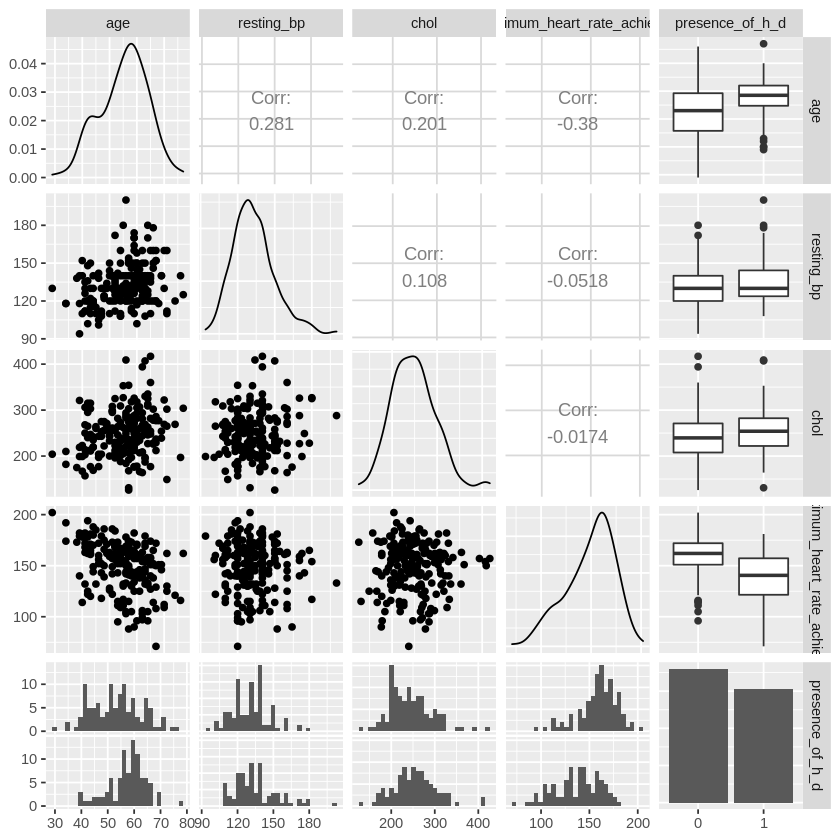

In [6]:
# scaled_training <- training_data %>% mutate(
# s_age = scale(age, center=TRUE),
#     s_resting_bp = scale(resting_bp, center=TRUE),
#     s_chol = scale(chol, center=TRUE),
#     s_maximum_heart_rate_achieved = scale(maximum_heart_rate_achieved, center=TRUE)) %>% select(-age, -resting_bp, -maximum_heart_rate_achieved, -chol)

# scaled_training
ggpairs(training_data)

Figure 1 - 

Scaled the training data

In [8]:
data_mean <- modify(training_data, mean) %>% head(1)

data_mean

Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”


age,resting_bp,chol,maximum_heart_rate_achieved,presence_of_h_d
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
55.235,132.84,248.2,149.16,NA


Note:
There is no missing data in the training data set.

#### Visualization example

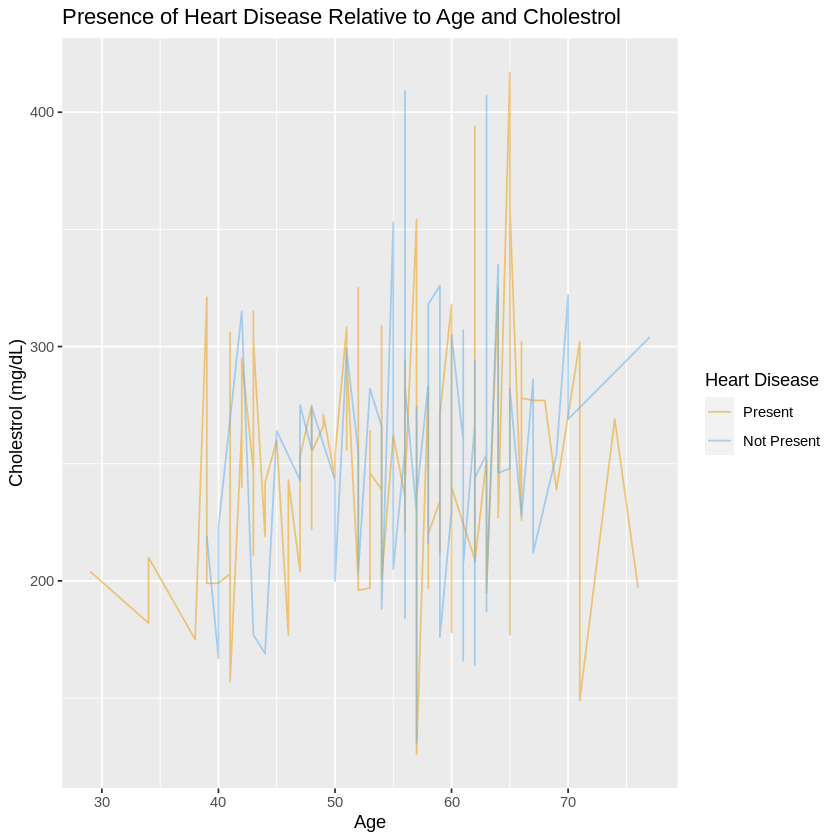

In [9]:
my_plot<- training_data %>%
       ggplot(aes(x = age, y = chol, color = presence_of_h_d)) +
       geom_line(alpha = 0.5)+
        scale_color_manual(labels = c("Present", "Not Present"), 
                     values = c("orange2", "steelblue2")) + 
       labs(x = "Age", y = "Cholestrol (mg/dL)", color = "Heart Disease") +
       ggtitle("Presence of Heart Disease Relative to Age and Cholestrol")

my_plot

Figure 2

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6568627
kap,binary,0.2997254


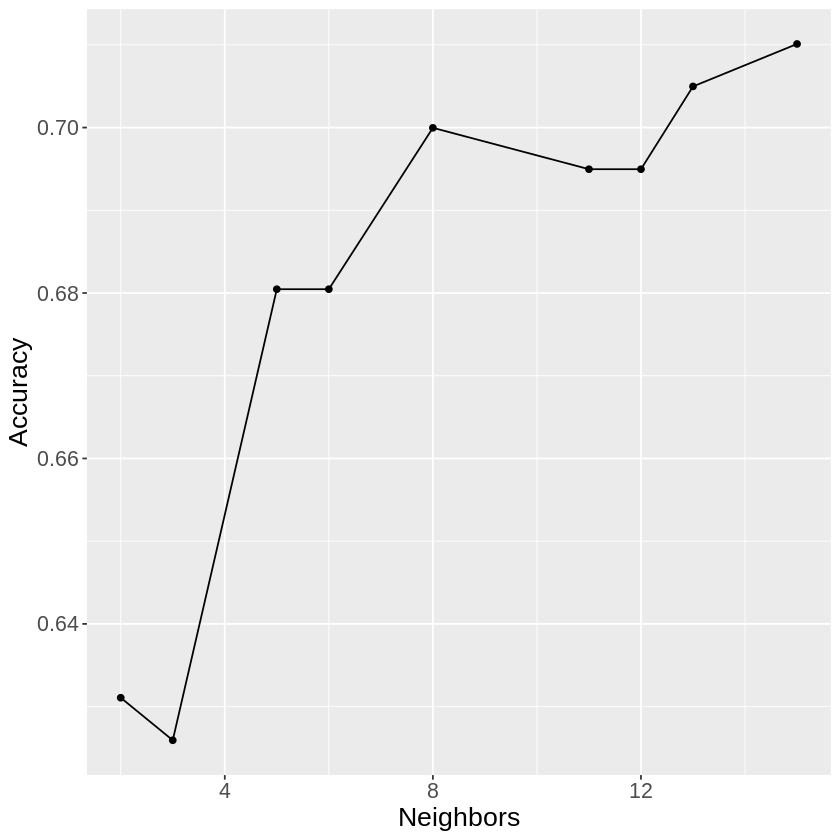

In [11]:
set.seed(2000)
recipe <- recipe(presence_of_h_d ~ ., data = training_data) %>% step_scale(all_predictors()) %>% step_center(all_predictors())
recipe

train_vfold <- vfold_cv(training_data, v = 5, strata = presence_of_h_d)

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")

training_fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(spec) %>%
      tune_grid(resamples = train_vfold, grid = 10) %>%
      collect_metrics() 

# training_fit

accuracies <- training_fit %>% 
      filter(.metric == "accuracy")

cross_val_plot <- accuracies %>%
     ggplot(aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy") +
     theme(text = element_text (size = 16))

cross_val_plot

k_for_all <- 13

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_for_all) %>%
      set_engine("kknn") %>%
      set_mode("classification")

fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(spec) %>%
      fit(data = training_data)

predictions_all <-predict(fit, testing_data) %>% bind_cols(testing_data) %>% metrics(truth = presence_of_h_d, estimate = .pred_class)
predictions_all

Figure 3

#### Methods

For this project, we will use cleveland.data and the following five factors: age, sex, resting blood pressure, cholesterol level, maximum heart rate achieved, and the presence of heart disease. We chose these attributes because previous research from Texas Heart Institute indicates these as some of the risk factors in developing heart disease.
To conduct our analysis, we will first wrangle the data by selecting and filtering for the data we need and mutating it to be more easily read (e.g. from genders 0 and 1 into female and male). Then we will split the data into training and testing data, where we will train a k-nearest neighbor model using the five attributes as predictors and test it on our test data. Finally, we will use a bar chart to visualize our results and help us determine the top three attributes.


#### Expected Outcomes and Significance

Out of our selected factors, we expect to find cholesterol level, age, and maximum heart rate achieved to be the three attributes with the strongest correlation to heart disease. We based our expectations on previous research and common factors that increase one’s risk of developing heart disease.
These findings can contribute to the current knowledge of factors that increase the risk of developing heart disease. Identifying the most influential components may help people decrease their odds of heart disease upon knowing which things are at play.
Our findings prompt the question: How do the classified attributes determining the presence of heart disease differ between demographics? 
